In [1]:
# Clone this repository:
!git clone https://github.com/adarshdotexe/IndoML.git
%cd /content/IndoML

^C


In [ ]:
# Install the requirements:
%pip install torch transformers datasets sentencepiece rouge-score nltk

In [2]:
# Import the required libraries:
import json
import torch
import random
import numpy as np
from datasets import load_metric
from sklearn.model_selection import train_test_split

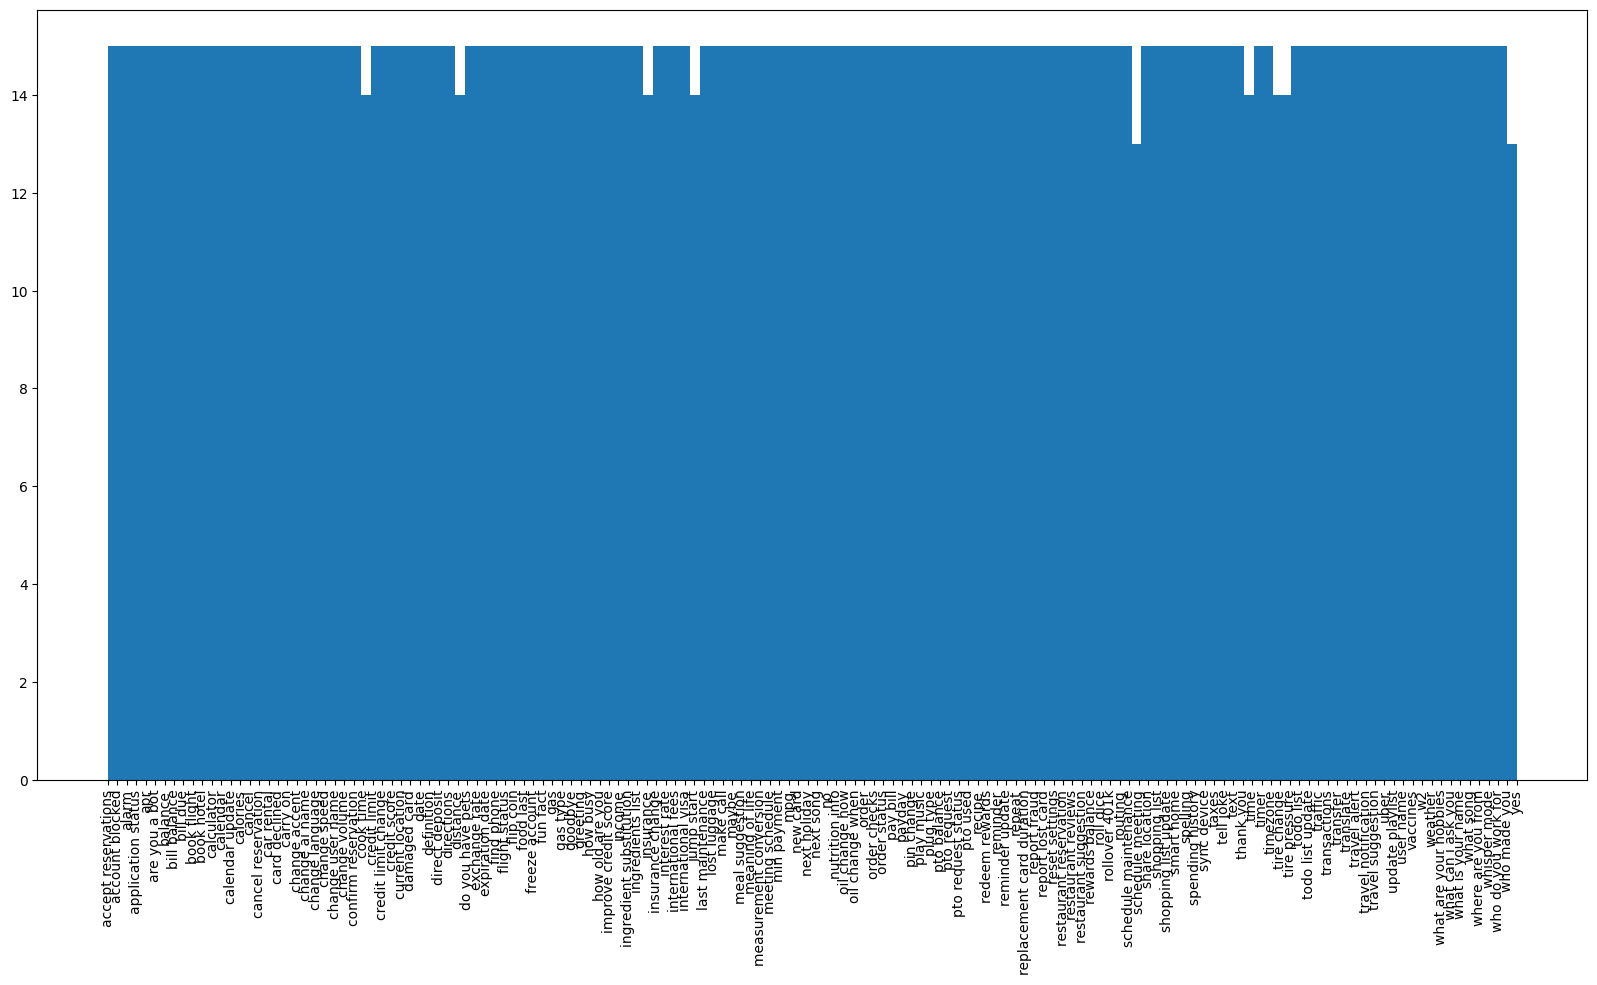

In [12]:
with open('train.json') as f:
    data = json.load(f)

utt = []
intent = []
classes = []

for i in data:
    utt.extend(i['utt'])
    intent.extend([i['intent'] for _ in i['utt']])
    classes.append(i['intent'])


# Shuffle the data:
random.seed(42)
arr = [i for i in range(len(utt))]
random.shuffle(arr)
utt = [utt[i] for i in arr]
intent = [intent[i] for i in arr]

# Split the data into train and test sets:
train_utt, test_utt, train_intent, test_intent = train_test_split(utt, intent, test_size=0.33, random_state=42)

In [ ]:
# Load the model:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EvalPrediction
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', num_labels=len(set(classes)), id2label={str(i): j for i, j in enumerate(set(classes))}, label2id={j: i for i, j in enumerate(set(classes))}, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [ ]:

# Encode the data:
dummy_encodings = tokenizer(["" for _ in train_utt], truncation=True, padding=True)
train_encodings = tokenizer(train_utt, truncation=True, padding=True)
test_encodings = tokenizer(test_utt, truncation=True, padding=True)

# Convert the data into torch tensors:
class IndoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = [classes.index(i) for i in labels]
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = IndoDataset(train_encodings, train_intent)
test_dataset = IndoDataset(test_encodings, test_intent)

# Define the compute metrics function:
def compute_metrics(p: EvalPrediction):
  metric_acc = load_metric("accuracy")
  metric_f1 = load_metric("f1")
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  preds = np.argmax(preds, axis = 1)
  result = {}
  result["accuracy"] = metric_acc.compute(predictions = preds, references = p.label_ids)["accuracy"]
  result["f1"] = metric_f1.compute(predictions = preds, references = p.label_ids, average = 'macro')["f1"]
  return result

# Define the training arguments:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

# Define the trainer:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

# Train the model:
trainer.train()

In [ ]:
# Load the augmented data:
with open('train_aug.json') as f:
    data_aug = json.load(f)

utt_aug = []
intent_aug = []

for i in data_aug:
    utt_aug.extend(i['utt'])
    intent_aug.extend([i['intent'] for _ in i['utt']])

# Encode the augmented data:
train_aug_encodings = tokenizer(utt_aug, truncation=True, padding=True)

# Convert the augmented data into torch tensors:
train_aug_dataset = IndoDataset(train_aug_encodings, intent_aug)

preds = trainer.predict(train_aug_dataset)
if isinstance(preds.predictions, tuple):
    preds = preds.predictions[0]



In [ ]:
trainer.train_dataset = train_dataset
trainer.train()

In [ ]:
preds_new = trainer.predict(train_aug_dataset)
if isinstance(preds_new.predictions, tuple):
    preds_new = preds_new.predictions[0]

# Calculate the per intent average of difference in predicted probabilities of augmented data:
diff = {}
for i in range(len(intent_aug)):
    if intent_aug[i] not in diff:
        diff[intent_aug[i]] = []
    diff[intent_aug[i]].append(preds_new[i][classes.index(intent_aug[i])] - preds[i][classes.index(intent_aug[i])])

for i in diff:
    diff[i] = sum(diff[i])/len(diff[i])

# Remove the utterances with difference in predicted probabilities less than mean of difference in predicted probabilities:
utt_aug_new = []
intent_aug_new = []
for i in range(len(intent_aug)):
    if preds_new[i][classes.index(intent_aug[i])] - preds[i][classes.index(intent_aug[i])] >= max(diff[intent_aug[i]], 1):
        utt_aug_new.append(utt_aug[i])
        intent_aug_new.append(intent_aug[i])

# Save the augmented data:
with open('train_aug_new.json', 'w') as f:
    json.dump({'utt': utt_aug_new, 'intent': intent_aug_new}, f, indent=4)



In [ ]:
# Now we use trainer to predict the labels for the massive test set:
test = []
with open('massive_test.data') as f:
    for i in f:
        test.append(json.loads(i))
result = []
for i in test:
    seq = []
    for j in classes:
        seq.append(i['utt'] + tokenizer.sep_token + f"This is {j}")
    encodings = tokenizer(seq, truncation = True, padding = True)
    dataset = IndoDataset(encodings, [0]*len(seq))
    predictions = trainer.predict(dataset)
    preds = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
    preds = [preds[i][0]/(preds[i][0] + preds[i][2]) for i in range(len(preds))]
    preds = np.argmax(preds)
    # {"indoml_id": 5846, "utt": "Could you please order me a new set of golf clubs?"}
    result.append({"indoml_id": i['indoml_id'], "intent": classes[preds]})
    print(i['utt'], classes[preds])

with open('massive_test_adarshdotexe', 'w') as f:
    for i in result:
        f.write(json.dumps(i) + '\n')